# <b>Ordinal Regression with a Tabular Wine Quality Dataset</b>


In [ ]:
# !pip install catboost
# !pip install optuna

## 1. Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import random
import os

# Scikit-learn
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_predict
from sklearn.metrics import cohen_kappa_score

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ML Model
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, Pool

# optuna
import optuna
from optuna.samplers import TPESampler

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### 1-1. Fixed Seed

In [ ]:
def seed_everything(seed: int=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

## 2. Load Data
`train.csv`: 학습 데이터, 타겟: cost<br>
`test.csv`: 테스트 데이터 <br>

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
train_df.head()

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,8.0,0.50,0.39,2.2,0.073,30.0,39.0,0.99572,3.33,0.77,12.1,6
1,1,9.3,0.30,0.73,2.3,0.092,30.0,67.0,0.99854,3.32,0.67,12.8,6
2,2,7.1,0.51,0.03,2.1,0.059,3.0,12.0,0.99660,3.52,0.73,11.3,7
3,3,8.1,0.87,0.22,2.6,0.084,11.0,65.0,0.99730,3.20,0.53,9.8,5
4,4,8.5,0.36,0.30,2.3,0.079,10.0,45.0,0.99444,3.20,1.36,9.5,6


In [ ]:
train_df.head()

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,8.0,0.50,0.39,2.2,0.073,30.0,39.0,0.99572,3.33,0.77,12.1,6
1,1,9.3,0.30,0.73,2.3,0.092,30.0,67.0,0.99854,3.32,0.67,12.8,6
2,2,7.1,0.51,0.03,2.1,0.059,3.0,12.0,0.99660,3.52,0.73,11.3,7
3,3,8.1,0.87,0.22,2.6,0.084,11.0,65.0,0.99730,3.20,0.53,9.8,5
4,4,8.5,0.36,0.30,2.3,0.079,10.0,45.0,0.99444,3.20,1.36,9.5,6


### 2-1. 데이터 설명

In [ ]:
def data_describe(df, title):
    print(f'====================== {title} Data Describe ======================')
    print(f'Row: {df.shape[0]}, Column: {df.shape[1]}')
    columns = df.columns
    data_type = []

    for col in columns:
        data_type.append(df[col].dtype)

    n_uniq = df.nunique()
    n_miss = df.isna().sum()

    names = list(zip(columns, data_type, n_uniq, n_miss))
    variable_desc = pd.DataFrame(names, columns=['Column', 'Dtype', 'Unique levels', 'Missing Count'])
    print(variable_desc)

In [ ]:
data_describe(train_df, 'Train')

====================== Train Data Describe ======================
Row: 2056, Column: 13
                  Column    Dtype  Unique levels  Missing Count
0                     Id    int64           2056              0
1          fixed acidity  float64             87              0
2       volatile acidity  float64            113              0
3            citric acid  float64             71              0
4         residual sugar  float64             66              0
5              chlorides  float64            103              0
6    free sulfur dioxide  float64             49              0
7   total sulfur dioxide  float64            126              0
8                density  float64            313              0
9                     pH  float64             77              0
10             sulphates  float64             73              0
11               alcohol  float64             53              0
12               quality    int64              6              0


In [ ]:
data_describe(test_df, 'Test')

====================== Test Data Describe ======================
Row: 1372, Column: 12
                  Column    Dtype  Unique levels  Missing Count
0                     Id    int64           1372              0
1          fixed acidity  float64             79              0
2       volatile acidity  float64            109              0
3            citric acid  float64             70              0
4         residual sugar  float64             56              0
5              chlorides  float64             97              0
6    free sulfur dioxide  float64             46              0
7   total sulfur dioxide  float64            122              0
8                density  float64            286              0
9                     pH  float64             75              0
10             sulphates  float64             72              0
11               alcohol  float64             52              0


In [ ]:
# Drop the 'Id' column from both train_df and test_df
train_df.drop('Id', axis=1, inplace=True)
test_df.drop('Id', axis=1, inplace=True)

## 3. EDA

### 3-1. Features distribution

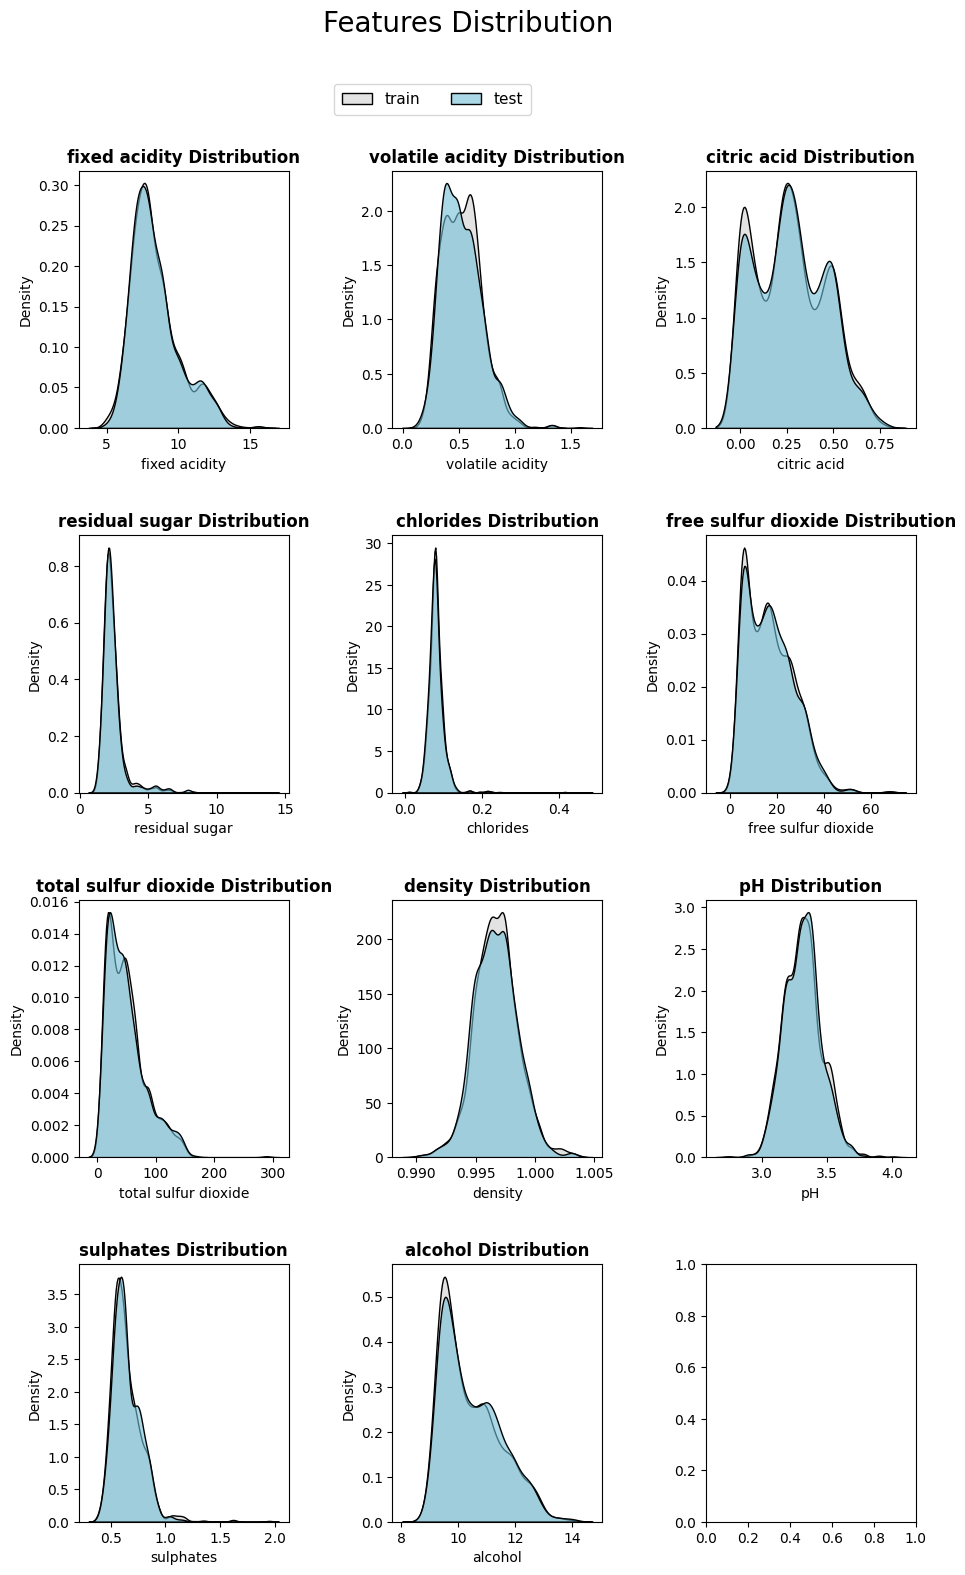

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(10, 15))
ax = ax.flatten()

for idx, column in enumerate(test_df.columns):
    sns.kdeplot(train_df[column], ax=ax[idx], color='#d1d1d1', shade=True, label='train', alpha=0.6, edgecolor='black')
    sns.kdeplot(test_df[column], ax=ax[idx], color='#72bfd6', shade=True, label='train', alpha=0.6, edgecolor='black')
    ax[idx].set_title(f'{column} Distribution', fontweight='bold')
fig.tight_layout(pad=3)
fig.legend(['train', 'test'], bbox_to_anchor=(0.57, 1.02), ncol=3, borderpad=0.5, frameon=True, fontsize=11, title_fontsize=12)
plt.figtext(0.5, 1.05, 'Features Distribution', size=20, ha='center')
plt.show()

### 3-2. Target distribution

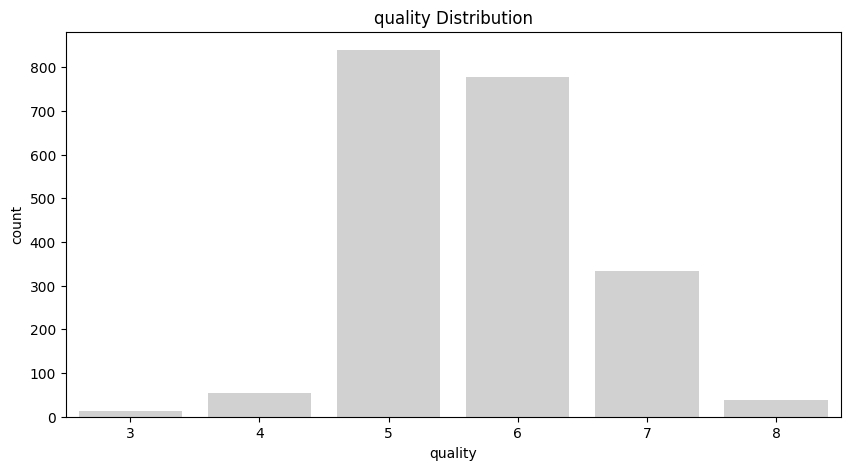

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(data=train_df, x='quality', color='#d1d1d1')
plt.title('quality Distribution')
plt.show()

### 3-3. Correlation map

In [ ]:
def show_corr_heatmap(df, title):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(15, 10))
    plt.title(title)
    sns.heatmap(corr, annot=True, linewidths=.5, fmt='.2f', vmax=1, vmin=-1,
                square=True, mask = mask, cmap='RdYlBu_r')
    plt.show()

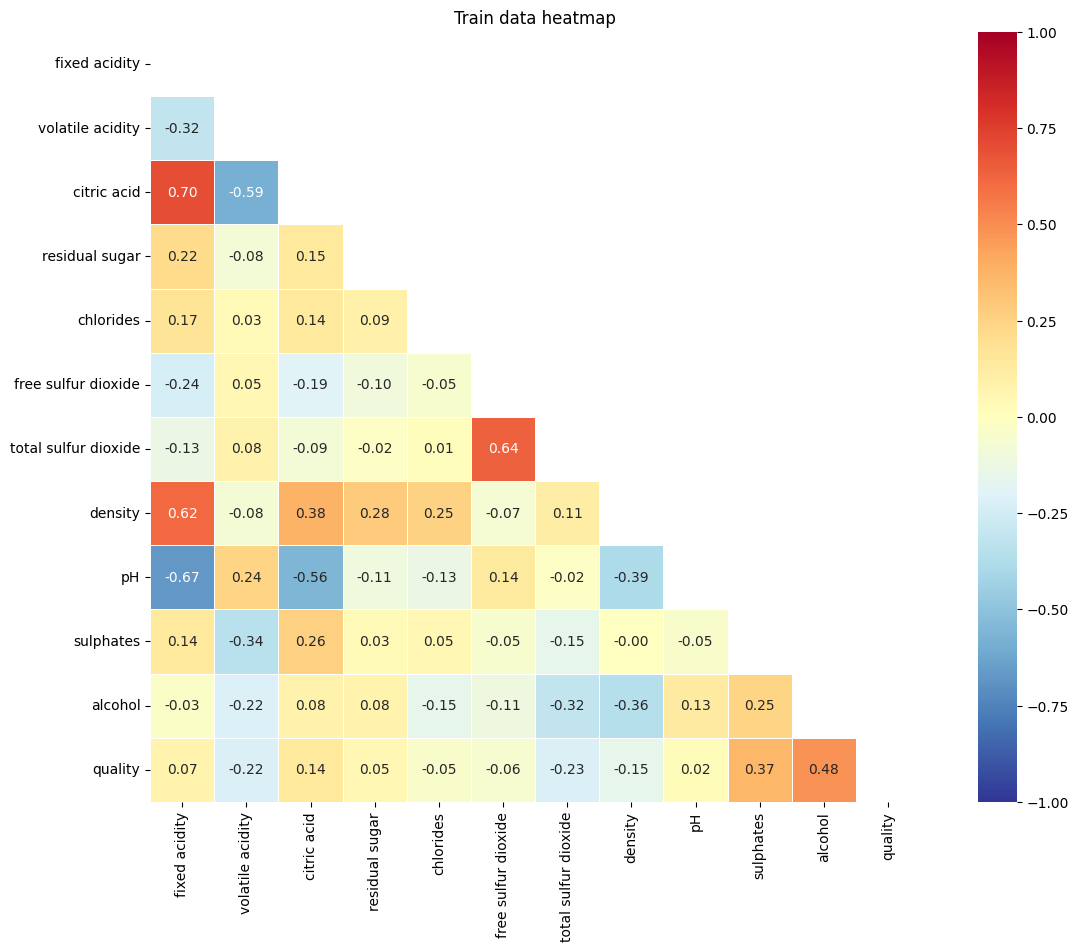

In [ ]:
show_corr_heatmap(train_df, 'Train data heatmap')

## 4. Preprocessing

In [ ]:
class WineDataProcessor:
    def __init__(self, train_df, test_df):
        self.train_df = train_df
        self.test_df = test_df

    def add_columns(self, df):
        df['total_acid'] = df['fixed acidity'] + df['volatile acidity'] + df['citric acid']
        df['acid/density'] = df['total_acid']  / df['density']
        df['alcohol_density'] = df['alcohol']  * df['density']
        df['sulphate/density'] = df['sulphates']  / df['density']
        df['sulphates/acid'] = df['sulphates'] / df['volatile acidity']
        df['sulphates/chlorides'] = df['sulphates'] / df['chlorides']
        df['sulphates*alcohol'] = df['sulphates'] / df['alcohol']
        return df

    def process_data(self):
        self.train_df = self.add_columns(self.train_df).assign(
            pH_round1 = self.train_df['pH'].round(1),
            log1p_residual_sugar = np.log1p(self.train_df['residual sugar']),
            citric_acid_per_alcohol = np.where(self.train_df['alcohol'] == 0, 0, self.train_df['citric acid'] / self.train_df['alcohol']),
        ).assign(
            citric_acid_type = lambda df: df['citric acid'].apply(lambda x: 0 if x == 0 else (1 if x == 0.49 else 2)),
            alcohol_mean_groupby_pH = lambda df: df.groupby('pH_round1')['alcohol'].transform('mean')
        )

        self.test_df = self.add_columns(self.test_df).assign(
            pH_round1 = self.test_df['pH'].round(1),
            log1p_residual_sugar = np.log1p(self.test_df['residual sugar']),
            citric_acid_per_alcohol = np.where(self.test_df['alcohol'] == 0, 0, self.test_df['citric acid'] / self.test_df['alcohol']),
        ).assign(
            citric_acid_type = lambda df: df['citric acid'].apply(lambda x: 0 if x == 0 else (1 if x == 0.49 else 2)),
            alcohol_mean_groupby_pH = lambda df: df.groupby('pH_round1')['alcohol'].transform('mean')
        )

        return self.train_df, self.test_df

In [ ]:
# Initialize the WineDataProcessor and process the data
processor = WineDataProcessor(train_df, test_df)
train_df, test_df = processor.process_data()

In [ ]:
# Define the features and target for modeling
features = ['sulphate/density', 'alcohol_density', 'alcohol', 'sulphates']
target = 'quality'

In [ ]:
# Change the quality column to 0, 1, 2, 3, 4, 5
train_df['quality'] = train_df['quality'] - 3

### 4-1. Feature Engineering
- K-means, PCA

K-means

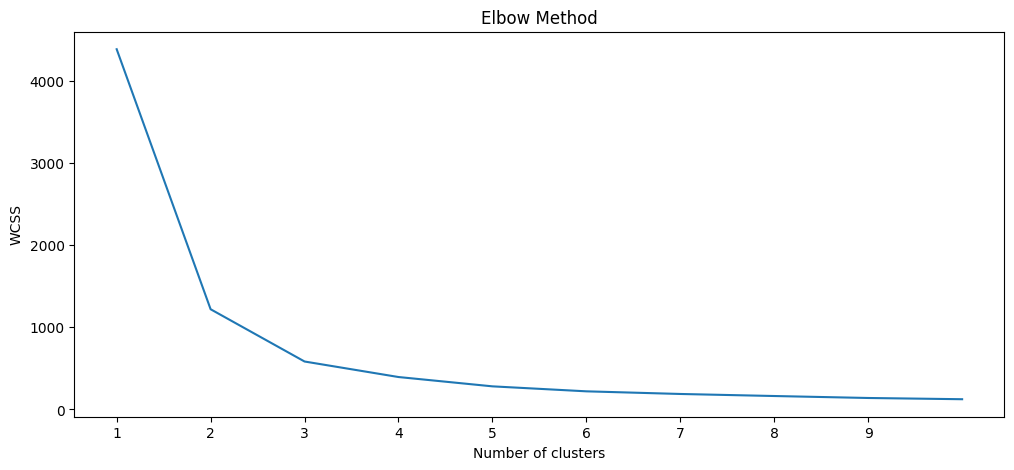

In [ ]:
def find_best_n_clusters(data, max_clusters=10):
    """
    Find the best number of clusters for KMeans algorithm using the elbow method.
    """
    # Initialise list to store within-cluster sum of squared distances
    wcss = []

    for n in range(1, max_clusters+1):
        # Initialize and fit KMeans model
        kmeans = KMeans(n_clusters=n, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(data)

        # Append the within-cluster sum of squared distances to the list
        wcss.append(kmeans.inertia_)

    # Plot the elbow graph
    x = [1, 2, 3, 4, 5, 6, 7, 8, 9]

    fig, ax = plt.subplots(figsize=(12,5))
    plt.plot(range(1, max_clusters+1), wcss)

    # Set the x axis labels to integers
    ax.xaxis.set_ticks(x)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

find_best_n_clusters(train_df[features].values)

PCA

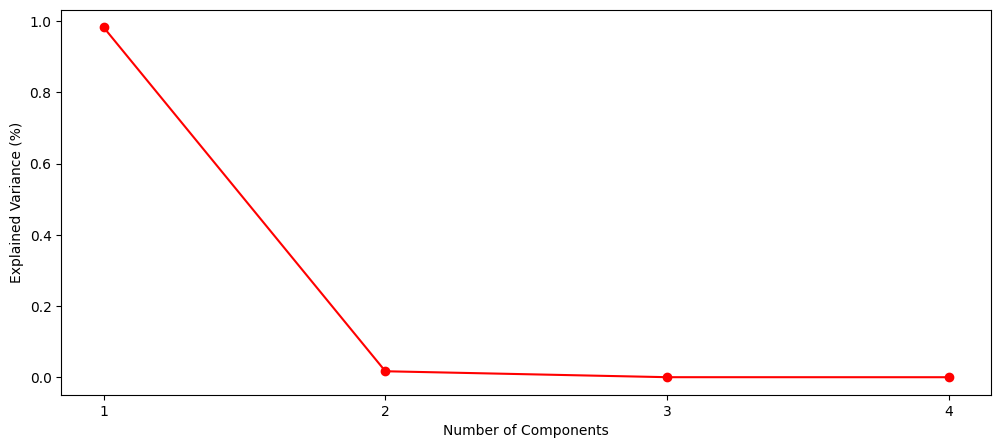

1

In [ ]:
def find_optimal_num_components(X):
    pca = PCA()
    pca.fit(X)
    explained_variance = pca.explained_variance_ratio_
    num_components = np.arange(len(explained_variance)) + 1

    # Plot the elbow graph
    x = [1, 2, 3, 4]
    fig, ax = plt.subplots(figsize=(12,5))
    plt.plot(num_components, explained_variance, 'ro-')
    ax.xaxis.set_ticks(x)
    plt.xlabel("Number of Components")
    plt.ylabel("Explained Variance (%)")
    plt.show()

    optimal_num_components = None
    for i in range(len(explained_variance) - 1):
        if explained_variance[i] >= 0.95 * explained_variance[i + 1]:
            optimal_num_components = i + 1
            break
    return optimal_num_components

find_optimal_num_components(train_df[features].values)

In [ ]:
def create_new_features(train_df, test_df, features):
    # Standardise the features for KMeans
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df[features])

    # Perform KMeans clustering on the training data
    kmeans = KMeans(n_clusters=3, random_state=0)
    kmeans.fit(X_train)

    # Reduce the dimensions of the training data using PCA
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train)
    train_df["cluster"] = kmeans.labels_
    train_df["pca_1"] = X_train_pca[:, 0]
    train_df["pca_2"] = X_train_pca[:, 1]

    # Standardise the features for KMeans
    X_test = scaler.transform(test_df[features])

    # Reduce the dimensions of the test data using PCA
    X_test_pca = pca.transform(X_test)
    test_df["cluster"] = kmeans.predict(X_test)
    test_df["pca_1"] = X_test_pca[:, 0]
    test_df["pca_2"] = X_test_pca[:, 1]

    return train_df, test_df

train_df, test_df = create_new_features(train_df, test_df, features)
features = [i for i in train_df.columns if i != 'quality']

## 5. Train Model
- 평가지표: `Quadratic weighted kappa`

### 5-1. Train XGBoost, LightGBM, CatBoost Model

In [ ]:
xgb_params_best={
    "max_depth": 3,
    "learning_rate": 0.2908331559320798,
    "n_estimators": 573
    }

lgb_params_best = {
    "boosting_type": "goss",
    "num_leaves": 60,
    "learning_rate": 0.21054071748114178,
    "n_estimators": 479,
    "max_depth": 7,
    "min_child_samples": 193,
    "subsample": 0.5669437422243876,
    "colsample_bytree": 0.47626537911344274,
    "reg_alpha": 0.9998325542320676,
    "reg_lambda": 0.7675133032375039
    }

cat_params_best = {
    'iterations':500,
    'depth': 4,
    'learning_rate': 0.081768171103716,
    'l2_leaf_reg': 128.43966591023685,
    }

In [ ]:
k = 10
cv = StratifiedKFold(k, shuffle=True, random_state=42)

# Initialise empty lists to store the results of each fold
fold_scores = []
test_preds = []
oof_preds = []
oof_true = []

# Loop over the training and validation indices for each fold
for i, (train_idx, val_idx) in enumerate(cv.split(train_df[features], train_df[target])):

    # Split the training and validation sets
    X_train = train_df.loc[train_idx, features]
    y_train = train_df.loc[train_idx, target]
    X_val = train_df.loc[val_idx, features]
    y_val = train_df.loc[val_idx, target]

    # Fit and make predictions with XGBoost model
    XGB_MODEL = xgb.XGBClassifier(**xgb_params_best)
    XGB_MODEL.fit(X_train, y_train, eval_set= [(X_val,y_val)], early_stopping_rounds = 200, verbose=200)
    XGB_pred = XGB_MODEL.predict(X_val)
    XGB_SCORE = cohen_kappa_score(y_val,XGB_pred,weights='quadratic')

    # Only consider the predictions from the models that perform well
    if XGB_SCORE > 0.36:
        test_preds.append(XGB_MODEL.predict(test_df[features]))
        fold_scores.append(XGB_SCORE)

    # Fit and make predictions with LightGBM model
    LGB_MODEL = lgb.LGBMClassifier(**lgb_params_best)
    LGB_MODEL.fit(X_train, y_train, eval_set= [(X_val,y_val)], early_stopping_rounds = 200, verbose=200)
    LGB_pred = LGB_MODEL.predict(X_val)
    LGB_SCORE = cohen_kappa_score(y_val,LGB_pred,weights='quadratic')

    # Only consider the predictions from the models that perform well
    if LGB_SCORE > 0.36:
        test_preds.append(LGB_MODEL.predict(test_df[features]))
        fold_scores.append(LGB_SCORE)

    # Fit and make predictions with LightGBM model
    CAT_MODEL = CatBoostClassifier(**cat_params_best)
    train_pool = Pool(X_train, y_train)
    test_pool = Pool(X_val, y_val)
    CAT_MODEL.fit(train_pool, eval_set= [test_pool], early_stopping_rounds = 200, verbose=200)
    CAT_pred = CAT_MODEL.predict(X_val).reshape(-1)
    CAT_SCORE = cohen_kappa_score(y_val,CAT_pred,weights='quadratic')

    # Only consider the predictions from the models that perform well
    if CAT_SCORE > 0.36:
        test_preds.append(CAT_MODEL.predict(test_df[features]).reshape(-1))
        fold_scores.append(CAT_SCORE)

    # Append the mean predictions for each fold to the oof_preds list
    oof_preds.extend(np.mean([
        XGB_pred,
        LGB_pred,
        CAT_pred
    ],axis=0))
    oof_true.extend(y_val)

[0]	validation_0-mlogloss:1.53980
[200]	validation_0-mlogloss:1.41953
[217]	validation_0-mlogloss:1.44788
[200]	valid_0's multi_logloss: 1.20338
0:	learn: 1.7439424	test: 1.7449800	best: 1.7449800 (0)	total: 62.1ms	remaining: 31s
200:	learn: 0.9709213	test: 1.0846846	best: 1.0846846 (200)	total: 1.98s	remaining: 2.94s
400:	learn: 0.9235013	test: 1.0819766	best: 1.0809012 (369)	total: 4.41s	remaining: 1.09s
499:	learn: 0.9053632	test: 1.0837374	best: 1.0809012 (369)	total: 5.53s	remaining: 0us

bestTest = 1.080901236
bestIteration = 369

Shrink model to first 370 iterations.
[0]	validation_0-mlogloss:1.50617
[200]	validation_0-mlogloss:1.21625
[216]	validation_0-mlogloss:1.23686
[200]	valid_0's multi_logloss: 1.0007
0:	learn: 1.7412129	test: 1.7348690	best: 1.7348690 (0)	total: 8.07ms	remaining: 4.03s
200:	learn: 0.9871629	test: 0.9499113	best: 0.9499113 (200)	total: 1.83s	remaining: 2.73s
400:	learn: 0.9416987	test: 0.9461854	best: 0.9458229 (389)	total: 4.45s	remaining: 1.1s
499:	lear

## 6. Submission

In [ ]:
class OptunaRounder:
    def __init__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred
        self.labels = np.unique(y_true)

    def __call__(self, trial):
        thresholds = []
        for i in range(len(self.labels) - 1):
            low = max(thresholds) if i > 0 else min(self.labels)
            high = max(self.labels)
            t = trial.suggest_float(f't{i}', low, high)
            thresholds.append(t)
        try:
            opt_y_pred = self.adjust(self.y_pred, thresholds)
        except: return 0
        return cohen_kappa_score(self.y_true, opt_y_pred, weights='quadratic')

    def adjust(self, y_pred, thresholds):
        opt_y_pred = pd.cut(y_pred,
                            [-np.inf] + thresholds + [np.inf],
                            labels=self.labels)
        return opt_y_pred

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
objective = OptunaRounder(oof_true, oof_preds)
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, timeout=100)

In [ ]:
# Best thresholds & score
best_thresholds = sorted(study.best_params.values())
print(f'Optimized thresholds: {best_thresholds}')

oof_pred_opt = objective.adjust(oof_preds, best_thresholds)
best_score = cohen_kappa_score(oof_true, oof_pred_opt, weights='quadratic')
print(f'Optimized OOF Score: {best_score:.5f}')

Optimized thresholds: [0.6451942241148602, 1.7813459170847548, 2.552700625396045, 3.0064073736455605, 4.875948162925505]
Optimized OOF Score: 0.53569


In [ ]:
submission = pd.read_csv('sample_submission.csv')
test_preds = np.array(test_preds).mean(axis=0)
opt_test_preds = objective.adjust(test_preds, best_thresholds).astype(int) + 3
submission['quality'] = opt_test_preds
submission.to_csv('submission.csv', index=False)

In [ ]:
submission.head()

,Id,quality
0,2056,5
1,2057,6
2,2058,5
3,2059,6
4,2060,6
